# Sweep Analysis Notebook

This notebook provides comprehensive analysis and visualization of hyperparameter sweep results from WandB.

## Features:
- Summary statistics of sweep parameters and metrics
- Cost vs Score scatter plot with level sets
- Time vs Score plot
- Time vs Cost plot
- Parameter correlation matrix
- Parameter importance analysis


In [133]:
# Settings Cell - Configure your sweep analysis here

# WandB Configuration
WANDB_ENTITY = "metta-research"  # Replace with your WandB entity
WANDB_PROJECT = "metta"  # Replace with your WandB project
WANDB_SWEEP_NAME = "axel.train_refactor.v1"  # Replace with your sweep name (group name)

# Analysis Configuration
MAX_OBSERVATIONS = 1000  # Maximum number of observations to load
TOP_K_PARAMETERS = 15  # Number of top parameters to show in importance plot
FIGURE_SIZE = (10, 8)  # Default figure size for plots
COLOR_PALETTE = "coolwarm"  # Color palette for visualizations


In [134]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from typing import Dict, List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Add the metta module to path if running from notebooks directory
sys.path.append(os.path.abspath('../..'))

# Import sweep utilities
from metta.sweep.wandb_utils import get_sweep_runs, deep_clean
import wandb

# Set seaborn style
sns.set_palette(COLOR_PALETTE)


In [135]:
# Helper functions for data processing

def flatten_nested_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '.') -> Dict[str, Any]:
    """Recursively flatten a nested dictionary structure."""
    items = []
    
    if not isinstance(d, dict):
        return {parent_key: d} if parent_key else {}
    
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            # Recursively flatten nested dictionaries
            items.extend(flatten_nested_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    
    return dict(items)

def extract_observations_to_dataframe(observations: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert protein observations to a pandas DataFrame with properly flattened hyperparameters."""
    
    all_rows = []
    
    for obs in observations:
        if obs.get('is_failure', False):
            continue
        
        row_data = {}
        
        # Get suggestion - should already be a dict thanks to deep_clean
        suggestion = obs.get('suggestion', {})
        
        # Flatten the suggestion dictionary to get all hyperparameters
        if isinstance(suggestion, dict) and suggestion:
            flattened = flatten_nested_dict(suggestion)
            row_data.update(flattened)
        
        # Add metrics directly
        row_data['score'] = obs.get('objective', np.nan)
        row_data['cost'] = obs.get('cost', np.nan)
        row_data['runtime'] = obs.get('cost', np.nan)
        row_data['timestamp'] = obs.get('timestamp', obs.get('created_at', np.nan))
        
        all_rows.append(row_data)
    
    # Create DataFrame from list of dictionaries
    df = pd.DataFrame(all_rows)
    
    # Convert timestamp to datetime
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df


In [136]:
# Load sweep data using get_sweep_runs from wandb_utils
print(f"Loading sweep data from WandB...")
print(f"Entity: {WANDB_ENTITY}")
print(f"Project: {WANDB_PROJECT}")
print(f"Sweep Name: {WANDB_SWEEP_NAME}")

# Use get_sweep_runs to fetch all runs from the sweep
from metta.sweep.wandb_utils import get_sweep_runs

runs = get_sweep_runs(
    sweep_name=WANDB_SWEEP_NAME,
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT
)

print(f"\nLoaded {len(runs)} runs")

# Extract observations and metadata from runs
observations = []
run_metadata = []

for run in runs[:MAX_OBSERVATIONS]:  # Limit to MAX_OBSERVATIONS
    # Get protein observation if it exists
    protein_obs = run.summary.get("protein_observation")
    
    # Also check for protein_suggestion if observation doesn't have suggestion
    protein_suggestion = run.summary.get("protein_suggestion")
    
    if protein_obs:
        # Use deep_clean to properly convert WandB objects to regular Python dicts
        obs = deep_clean(protein_obs)
        
        # If observation doesn't have suggestion but we have protein_suggestion, add it
        if 'suggestion' not in obs and protein_suggestion:
            obs['suggestion'] = deep_clean(protein_suggestion)
            
        obs['timestamp'] = run.created_at
        obs['run_name'] = run.name
        obs['run_id'] = run.id
        observations.append(obs)
    elif protein_suggestion:
        # If we only have protein_suggestion, create an observation from it
        obs = {
            'suggestion': deep_clean(protein_suggestion),
            'objective': run.summary.get('score', run.summary.get('protein.objective', np.nan)),
            'cost': run.summary.get('_wandb', {}).get('runtime', 0),
            'is_failure': run.state != 'finished',
            'timestamp': run.created_at,
            'run_name': run.name,
            'run_id': run.id
        }
        observations.append(obs)
        
    # Collect run metadata for cost analysis (all runs, not just with protein obs)
    metadata = {
        'run_id': run.id,
        'run_name': run.name,
        'timestamp': run.created_at,
        'runtime_seconds': run.summary.get('_wandb', {}).get('runtime', 0),
        'state': run.state,
        'score': run.summary.get('score', run.summary.get('protein.objective', 0))
    }
    
    # Try to get actual dollar cost from metadata
    # Check multiple possible locations for cost information
    dollar_cost = None
    if 'cost' in run.summary:
        dollar_cost = run.summary['cost']
    elif '_wandb' in run.summary and 'cost' in run.summary['_wandb']:
        dollar_cost = run.summary['_wandb']['cost']
    elif 'system' in run.summary and 'cost' in run.summary['system']:
        dollar_cost = run.summary['system']['cost']
    
    # If no cost found, estimate based on runtime (assuming $0.50 per hour as placeholder)
    if dollar_cost is None:
        runtime_hours = metadata['runtime_seconds'] / 3600
        dollar_cost = runtime_hours * 0.5  # $0.50 per hour estimate
        
    metadata['dollar_cost'] = dollar_cost
    run_metadata.append(metadata)

print(f"Valid observations with protein data: {len(observations)}")

# Convert observations to DataFrame
df = extract_observations_to_dataframe(observations)
print(f"Valid observations after filtering: {len(df)}")

# Create run metadata DataFrame for cost analysis
metadata_df = pd.DataFrame(run_metadata)
if not metadata_df.empty and 'timestamp' in metadata_df.columns:
    metadata_df['timestamp'] = pd.to_datetime(metadata_df['timestamp'])
    metadata_df = metadata_df.sort_values('timestamp').reset_index(drop=True)

# Show what parameters we found
param_cols = [col for col in df.columns if col not in ['score', 'cost', 'runtime', 'timestamp', 'run_name', 'run_id']]
print(f"\nFound {len(param_cols)} hyperparameters:")
if param_cols:
    for i, col in enumerate(param_cols[:10]):
        print(f"  - {col}")
    if len(param_cols) > 10:
        print(f"  ... and {len(param_cols) - 10} more")
        
# Show cost summary
if not metadata_df.empty and 'dollar_cost' in metadata_df.columns:
    total_cost = metadata_df['dollar_cost'].sum()
    print(f"\n💰 Total sweep cost: ${total_cost:.2f}")
    print(f"💵 Average cost per run: ${metadata_df['dollar_cost'].mean():.2f}")
    print(f"📊 Number of runs: {len(metadata_df)}")

Loading sweep data from WandB...
Entity: metta-research
Project: metta
Sweep Name: axel.train_refactor.v1

Loaded 54 runs
Valid observations with protein data: 54
Valid observations after filtering: 54

Found 11 hyperparameters:
  - trainer.optimizer.beta1
  - trainer.optimizer.beta2
  - trainer.optimizer.eps
  - trainer.optimizer.learning_rate
  - trainer.ppo.clip_coef
  - trainer.ppo.ent_coef
  - trainer.ppo.gae_lambda
  - trainer.ppo.gamma
  - trainer.ppo.vf_clip_coef
  - trainer.ppo.vf_coef
  ... and 1 more

💰 Total sweep cost: $2.07
💵 Average cost per run: $0.04
📊 Number of runs: 54


In [137]:
# Diagnostic: Check what columns we have in the DataFrame
print("DataFrame shape:", df.shape)
print("\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")
    
print("\nFirst few rows of data:")
df.head()


DataFrame shape: (54, 15)

Column names:
  1. trainer.optimizer.beta1
  2. trainer.optimizer.beta2
  3. trainer.optimizer.eps
  4. trainer.optimizer.learning_rate
  5. trainer.ppo.clip_coef
  6. trainer.ppo.ent_coef
  7. trainer.ppo.gae_lambda
  8. trainer.ppo.gamma
  9. trainer.ppo.vf_clip_coef
  10. trainer.ppo.vf_coef
  11. trainer.update_epochs
  12. score
  13. cost
  14. runtime
  15. timestamp

First few rows of data:


,trainer.optimizer.beta1,trainer.optimizer.beta2,trainer.optimizer.eps,trainer.optimizer.learning_rate,trainer.ppo.clip_coef,trainer.ppo.ent_coef,trainer.ppo.gae_lambda,trainer.ppo.gamma,trainer.ppo.vf_clip_coef,trainer.ppo.vf_coef,trainer.update_epochs,score,cost,runtime,timestamp
0,0.900000,0.999000,1.000000e-08,0.001000,0.200000,0.001000,0.950000,0.990000,10.000000,0.500000,3,0.059028,39.633952,39.633952,2025-08-04 17:30:52+00:00
1,0.914206,0.999000,2.052734e-07,0.000508,0.294175,0.001587,0.873395,0.996210,6.481044,0.573092,2,0.069444,37.045027,37.045027,2025-08-04 17:36:21+00:00
2,0.983436,0.998966,6.535917e-09,0.003064,0.371663,0.001243,0.835765,0.993644,2.766073,0.341173,3,0.027778,33.048072,33.048072,2025-08-04 17:40:28+00:00
3,0.816594,0.999000,5.555272e-07,0.000366,0.231893,0.000774,0.822207,0.996293,15.417966,0.730956,1,0.049306,33.165038,33.165038,2025-08-04 17:45:40+00:00
4,0.746164,0.999000,2.042674e-07,0.000354,0.247944,0.003109,0.964133,0.998158,2.544783,0.614169,3,0.060417,35.773213,35.773213,2025-08-04 17:48:39+00:00


In [138]:
# Show a sample observation to understand the structure
if observations:
    print("Sample observation structure:")
    import json
    print(json.dumps(observations[0], indent=2, default=str))


Sample observation structure:
{
  "cost": 33.21587586402893,
  "is_failure": false,
  "objective": 0.09027777762255734,
  "suggestion": {
    "trainer": {
      "optimizer": {
        "beta1": 0.9077644107486772,
        "beta2": 0.999,
        "eps": 1.630035861102361e-07,
        "learning_rate": 0.008898312612504896
      },
      "ppo": {
        "clip_coef": 0.1899249066918743,
        "ent_coef": 0.0020681515010908804,
        "gae_lambda": 0.984686077570158,
        "gamma": 0.9652148774172872,
        "vf_clip_coef": 7.7610321369413695,
        "vf_coef": 0.4100479286981519
      },
      "update_epochs": 2
    }
  },
  "timestamp": "2025-08-04T22:12:25Z",
  "run_name": "axel.train_refactor.v1.r.52",
  "run_id": "axel.train_refactor.v1.r.52"
}


## 1. Sweep Summary Statistics


In [139]:
# Calculate summary statistics
if not df.empty:
    # Identify parameter columns (exclude metrics)
    metric_cols = ['score', 'cost', 'time']
    param_cols = [col for col in df.columns if col not in metric_cols]
    
    # Get unique parameter values
    param_summary = {}
    for col in param_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            param_summary[col] = {
                'type': 'numeric',
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': df[col].std(),
                'unique_values': df[col].nunique()
            }
        else:
            param_summary[col] = {
                'type': 'categorical',
                'unique_values': df[col].nunique(),
                'values': df[col].unique().tolist()[:10]  # Show first 10 unique values
            }
    
    # Display sweep summary
    print("=" * 80)
    print("SWEEP SUMMARY")
    print("=" * 80)
    
    print(f"\nTotal Runs: {len(df)}")
    print(f"Successful Runs: {len(df[df['score'].notna()])}")
    print(f"Failed Runs: {len(observations) - len(df)}")
    
    print(f"\nMetrics Summary:")
    print(f"  Average Score: {df['score'].mean():.4f} (±{df['score'].std():.4f})")
    print(f"  Best Score: {df['score'].max():.4f}")
    print(f"  Worst Score: {df['score'].min():.4f}")
    
    print(f"\n  Average Run Time: {df['runtime'].mean():.2f} seconds")
    print(f"  Total Run Time: {df['runtime'].sum():.2f} seconds ({df['runtime'].sum()/3600:.2f} hours)")
    
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        print(f"\n  First Run: {df['timestamp'].min()}")
        print(f"  Last Run: {df['timestamp'].max()}")
        print(f"  Sweep Duration: {df['timestamp'].max() - df['timestamp'].min()}")
    
    print(f"\n  Average Cost: {df['cost'].mean():.2f}")
    print(f"  Total Cost: {df['cost'].sum():.2f}")
    
    print(f"\nParameters Being Swept ({len(param_cols)} total):")
    for i, (param, info) in enumerate(param_summary.items()):
        if i < 10:  # Show first 10 parameters
            if info['type'] == 'numeric':
                print(f"  - {param}: {info['min']:.4f} to {info['max']:.4f} ({info['unique_values']} unique values)")
            else:
                print(f"  - {param}: {info['unique_values']} unique values")
    
    if len(param_cols) > 10:
        print(f"  ... and {len(param_cols) - 10} more parameters")
else:
    print("No valid observations found in the sweep data.")


SWEEP SUMMARY

Total Runs: 54
Successful Runs: 54
Failed Runs: 0

Metrics Summary:
  Average Score: 0.0591 (±0.0141)
  Best Score: 0.0903
  Worst Score: 0.0278

  Average Run Time: 35.89 seconds
  Total Run Time: 1938.01 seconds (0.54 hours)

  First Run: 2025-08-04 17:30:52+00:00
  Last Run: 2025-08-04 22:26:11+00:00
  Sweep Duration: 0 days 04:55:19

  Average Cost: 35.89
  Total Cost: 1938.01

Parameters Being Swept (13 total):
  - trainer.optimizer.beta1: 0.3968 to 0.9863 (54 unique values)
  - trainer.optimizer.beta2: 0.9973 to 0.9990 (20 unique values)
  - trainer.optimizer.eps: 0.0000 to 0.0000 (52 unique values)
  - trainer.optimizer.learning_rate: 0.0000 to 0.0536 (51 unique values)
  - trainer.ppo.clip_coef: 0.0500 to 0.3717 (52 unique values)
  - trainer.ppo.ent_coef: 0.0006 to 0.0068 (54 unique values)
  - trainer.ppo.gae_lambda: 0.8222 to 0.9930 (54 unique values)
  - trainer.ppo.gamma: 0.9412 to 0.9982 (54 unique values)
  - trainer.ppo.vf_clip_coef: 2.5448 to 22.7314 (54

## 2. Dollar Cost Analysis

In [140]:
# Dollar Cost Analysis
if 'metadata_df' in locals() and not metadata_df.empty and 'dollar_cost' in metadata_df.columns:
    print("=" * 80)
    print("DOLLAR COST ANALYSIS")
    print("=" * 80)
    
    # Calculate cost statistics
    total_cost = metadata_df['dollar_cost'].sum()
    avg_cost = metadata_df['dollar_cost'].mean()
    median_cost = metadata_df['dollar_cost'].median()
    max_cost = metadata_df['dollar_cost'].max()
    min_cost = metadata_df['dollar_cost'].min()
    
    print(f"\n💰 Total Sweep Cost: ${total_cost:.2f}")
    print(f"💵 Average Cost per Run: ${avg_cost:.2f}")
    print(f"📊 Median Cost per Run: ${median_cost:.2f}")
    print(f"📈 Most Expensive Run: ${max_cost:.2f}")
    print(f"📉 Least Expensive Run: ${min_cost:.2f}")
    print(f"🔢 Number of Runs: {len(metadata_df)}")
    
    # Calculate cumulative cost
    metadata_df['cumulative_cost'] = metadata_df['dollar_cost'].cumsum()
    
    # Cost efficiency analysis
    if 'score' in metadata_df.columns:
        # Find best score and its cost
        best_run_idx = metadata_df['score'].idxmax()
        best_run = metadata_df.loc[best_run_idx]
        print(f"\n🏆 Best Run:")
        print(f"   - Score: {best_run['score']:.4f}")
        print(f"   - Cost: ${best_run['dollar_cost']:.2f}")
        print(f"   - Run Name: {best_run['run_name']}")
        
        # Calculate cost efficiency (score per dollar)
        metadata_df['cost_efficiency'] = metadata_df['score'] / (metadata_df['dollar_cost'] + 0.01)  # Add small value to avoid division by zero
        most_efficient_idx = metadata_df['cost_efficiency'].idxmax()
        most_efficient = metadata_df.loc[most_efficient_idx]
        print(f"\n⚡ Most Cost-Efficient Run:")
        print(f"   - Score: {most_efficient['score']:.4f}")
        print(f"   - Cost: ${most_efficient['dollar_cost']:.2f}")
        print(f"   - Efficiency: {most_efficient['cost_efficiency']:.4f} score/dollar")
        print(f"   - Run Name: {most_efficient['run_name']}")
    
    # Time-based cost analysis
    if 'timestamp' in metadata_df.columns:
        duration = metadata_df['timestamp'].max() - metadata_df['timestamp'].min()
        hours = duration.total_seconds() / 3600
        if hours > 0:
            cost_per_hour = total_cost / hours
            print(f"\n⏰ Time-based Analysis:")
            print(f"   - Sweep Duration: {duration}")
            print(f"   - Cost per Hour: ${cost_per_hour:.2f}")
else:
    print("No cost data available for analysis")


DOLLAR COST ANALYSIS

💰 Total Sweep Cost: $2.07
💵 Average Cost per Run: $0.04
📊 Median Cost per Run: $0.04
📈 Most Expensive Run: $0.16
📉 Least Expensive Run: $0.02
🔢 Number of Runs: 54

🏆 Best Run:
   - Score: 0.0903
   - Cost: $0.03
   - Run Name: axel.train_refactor.v1.r.52

⚡ Most Cost-Efficient Run:
   - Score: 0.0903
   - Cost: $0.03
   - Efficiency: 2.2337 score/dollar
   - Run Name: axel.train_refactor.v1.r.52

⏰ Time-based Analysis:
   - Sweep Duration: 0 days 04:55:19
   - Cost per Hour: $0.42


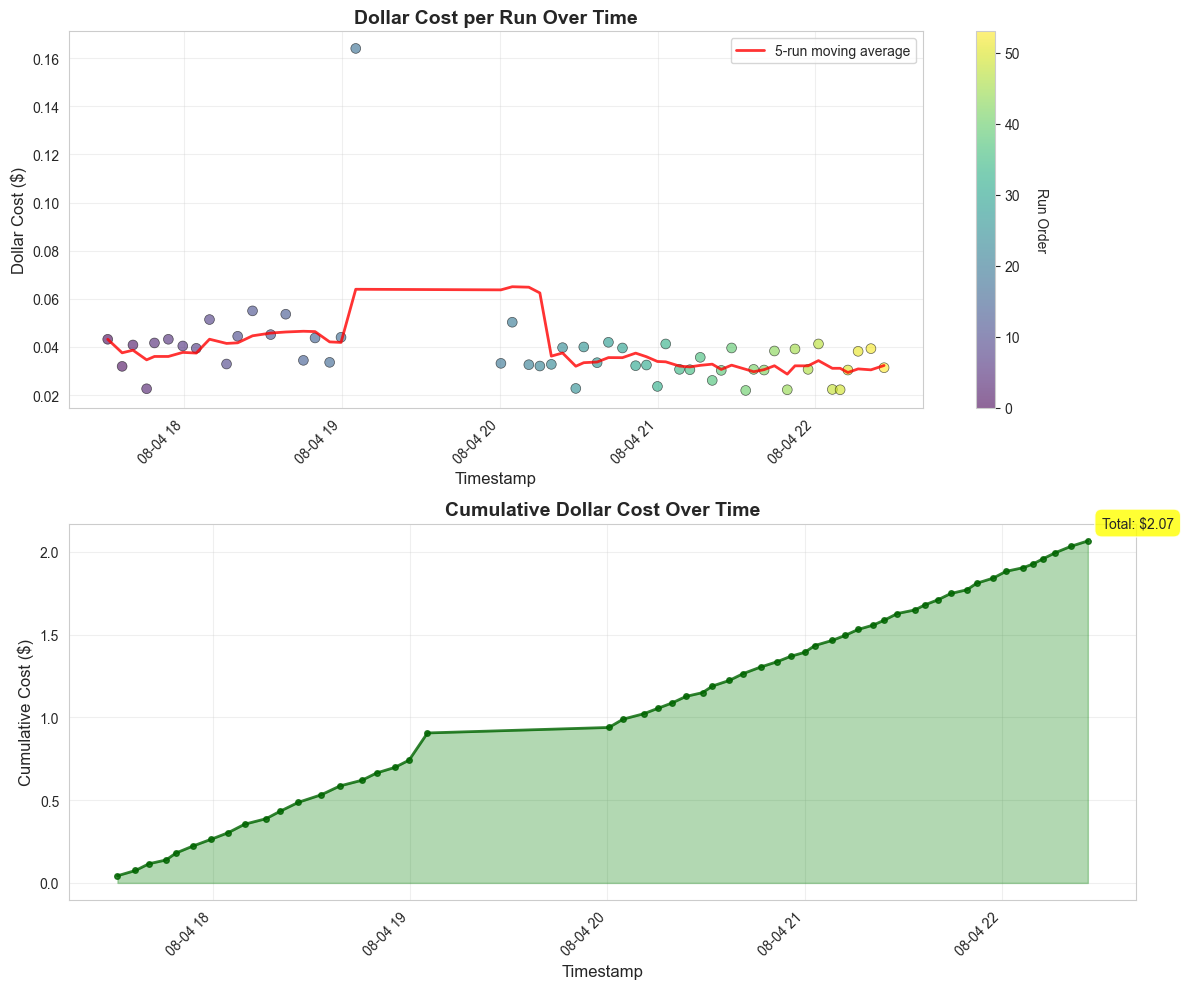

In [141]:
# Dollar Cost Visualization - Timeline
if 'metadata_df' in locals() and not metadata_df.empty and 'dollar_cost' in metadata_df.columns and 'timestamp' in metadata_df.columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top plot: Dollar cost per run over time
    scatter = ax1.scatter(metadata_df['timestamp'], metadata_df['dollar_cost'], 
                         alpha=0.6, s=50, c=range(len(metadata_df)), 
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    
    # Add moving average
    if len(metadata_df) >= 5:
        ax1.plot(metadata_df['timestamp'], 
                metadata_df['dollar_cost'].rolling(window=5, min_periods=1).mean(), 
                color='red', linewidth=2, alpha=0.8, label='5-run moving average')
    
    ax1.set_xlabel('Timestamp', fontsize=12)
    ax1.set_ylabel('Dollar Cost ($)', fontsize=12)
    ax1.set_title('Dollar Cost per Run Over Time', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Run Order', rotation=270, labelpad=20)
    
    # Bottom plot: Cumulative cost over time
    ax2.plot(metadata_df['timestamp'], metadata_df['cumulative_cost'], 
            color='darkgreen', linewidth=2, marker='o', markersize=4, alpha=0.8)
    
    # Fill area under the curve
    ax2.fill_between(metadata_df['timestamp'], 0, metadata_df['cumulative_cost'], 
                     alpha=0.3, color='green')
    
    # Add total cost annotation
    total_cost = metadata_df['cumulative_cost'].iloc[-1]
    ax2.annotate(f'Total: ${total_cost:.2f}', 
                xy=(metadata_df['timestamp'].iloc[-1], total_cost),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax2.set_xlabel('Timestamp', fontsize=12)
    ax2.set_ylabel('Cumulative Cost ($)', fontsize=12)
    ax2.set_title('Cumulative Dollar Cost Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for both plots
    for ax in [ax1, ax2]:
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("No cost timeline data available for visualization")


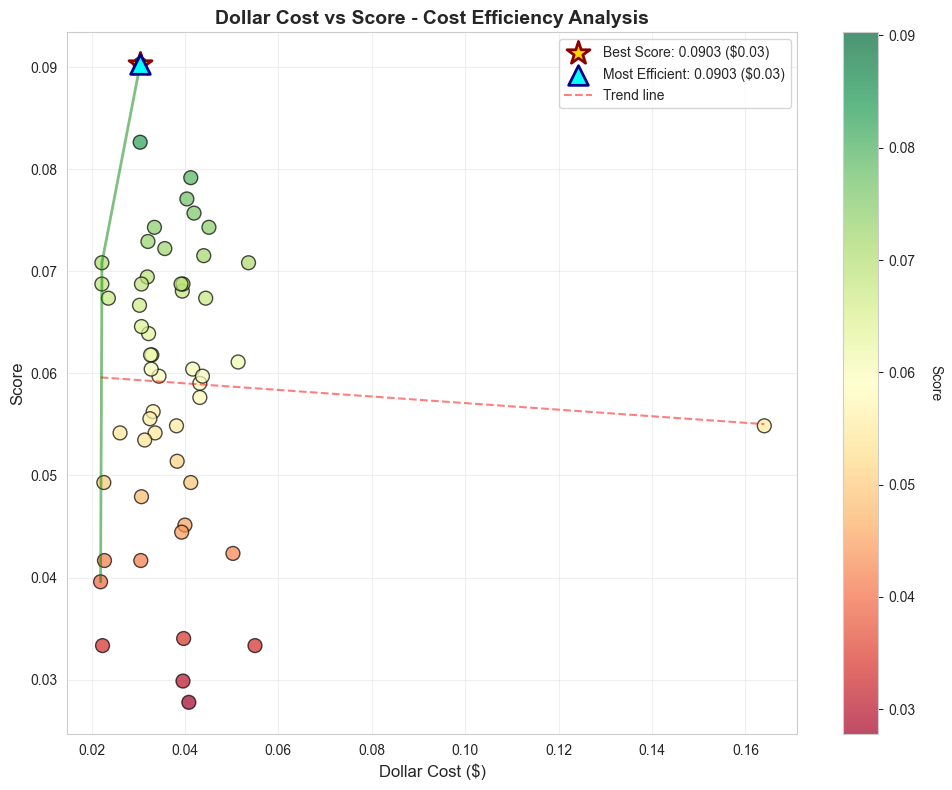

In [142]:
# Cost Efficiency Analysis - Dollar Cost vs Score
if 'metadata_df' in locals() and not metadata_df.empty and 'dollar_cost' in metadata_df.columns and 'score' in metadata_df.columns:
    plot_df = metadata_df[['dollar_cost', 'score']].dropna()
    
    if len(plot_df) > 0:
        fig, ax = plt.subplots(figsize=FIGURE_SIZE)
        
        # Create scatter plot with score as color
        scatter = ax.scatter(plot_df['dollar_cost'], plot_df['score'], 
                           c=plot_df['score'], s=100, cmap='RdYlGn', 
                           edgecolors='black', linewidth=1, alpha=0.7)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Score', rotation=270, labelpad=20)
        
        # Highlight best score
        best_idx = plot_df['score'].idxmax()
        ax.scatter(plot_df.loc[best_idx, 'dollar_cost'], 
                  plot_df.loc[best_idx, 'score'],
                  color='gold', s=300, marker='*', 
                  edgecolors='darkred', linewidth=2,
                  label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f} (${plot_df.loc[best_idx, "dollar_cost"]:.2f})',
                  zorder=100)
        
        # Highlight most cost-efficient
        if 'cost_efficiency' in metadata_df.columns:
            most_efficient_idx = metadata_df['cost_efficiency'].idxmax()
            if most_efficient_idx in plot_df.index:
                ax.scatter(plot_df.loc[most_efficient_idx, 'dollar_cost'], 
                          plot_df.loc[most_efficient_idx, 'score'],
                          color='cyan', s=200, marker='^', 
                          edgecolors='darkblue', linewidth=2,
                          label=f'Most Efficient: {plot_df.loc[most_efficient_idx, "score"]:.4f} (${plot_df.loc[most_efficient_idx, "dollar_cost"]:.2f})',
                          zorder=100)
        
        # Add trend line if enough points
        if len(plot_df) > 3:
            z = np.polyfit(plot_df['dollar_cost'], plot_df['score'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(plot_df['dollar_cost'].min(), plot_df['dollar_cost'].max(), 100)
            ax.plot(x_trend, p(x_trend), "r--", alpha=0.5, label='Trend line')
        
        ax.set_xlabel('Dollar Cost ($)', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Dollar Cost vs Score - Cost Efficiency Analysis', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add efficiency frontier (Pareto optimal points)
        # Sort by cost
        sorted_df = plot_df.sort_values('dollar_cost')
        pareto_points = []
        max_score = 0
        for idx, row in sorted_df.iterrows():
            if row['score'] > max_score:
                max_score = row['score']
                pareto_points.append((row['dollar_cost'], row['score']))
        
        if len(pareto_points) > 1:
            pareto_x, pareto_y = zip(*pareto_points)
            ax.plot(pareto_x, pareto_y, 'g-', linewidth=2, alpha=0.5, label='Efficiency Frontier')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid cost/score data for efficiency analysis")
else:
    print("Missing cost or score data for efficiency analysis")


## 3. Cost vs Score Scatter Plot with Level Sets


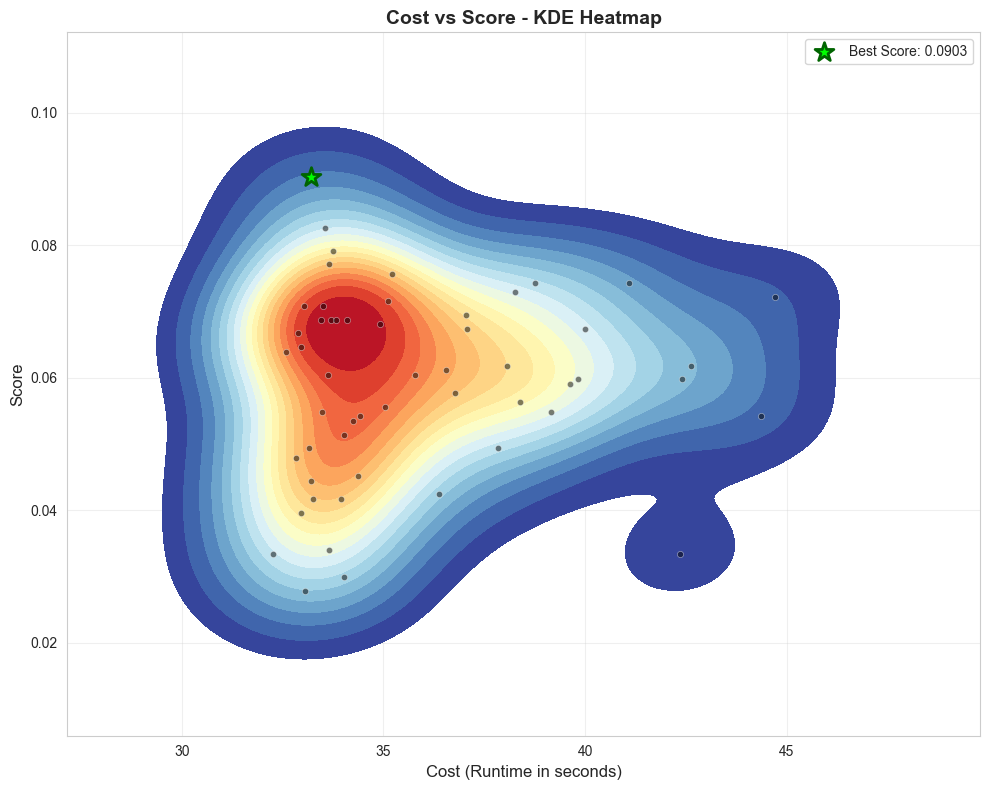

In [143]:
# Cost vs Score using Seaborn KDE (Kernel Density Estimation)
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        fig, ax = plt.subplots(figsize=FIGURE_SIZE)
        
        # KDE Heatmap
        try:
            # Create KDE plot with filled contours
            sns.kdeplot(
                data=plot_df,
                x='cost',
                y='score',
                fill=True,
                cmap='RdYlBu_r',
                levels=20,
                thresh=0.05,
                ax=ax
            )
            
            # Overlay scatter points
            ax.scatter(plot_df['cost'], plot_df['score'], 
                       alpha=0.5, s=20, c='black', edgecolors='white', 
                       linewidth=0.5, zorder=10)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax.scatter(plot_df.loc[best_idx, 'cost'], 
                       plot_df.loc[best_idx, 'score'],
                       color='lime', s=200, marker='*', 
                       edgecolors='darkgreen', linewidth=2,
                       label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f}',
                       zorder=20)
            
            ax.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Cost vs Score - KDE Heatmap', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"KDE plot failed: {e}")
            # Fallback to scatter plot if KDE fails
            ax.scatter(plot_df['cost'], plot_df['score'], 
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            ax.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Cost vs Score', fontsize=14, fontweight='bold')
            
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for density visualization")


## 3b. Advanced Cost vs Score Visualization

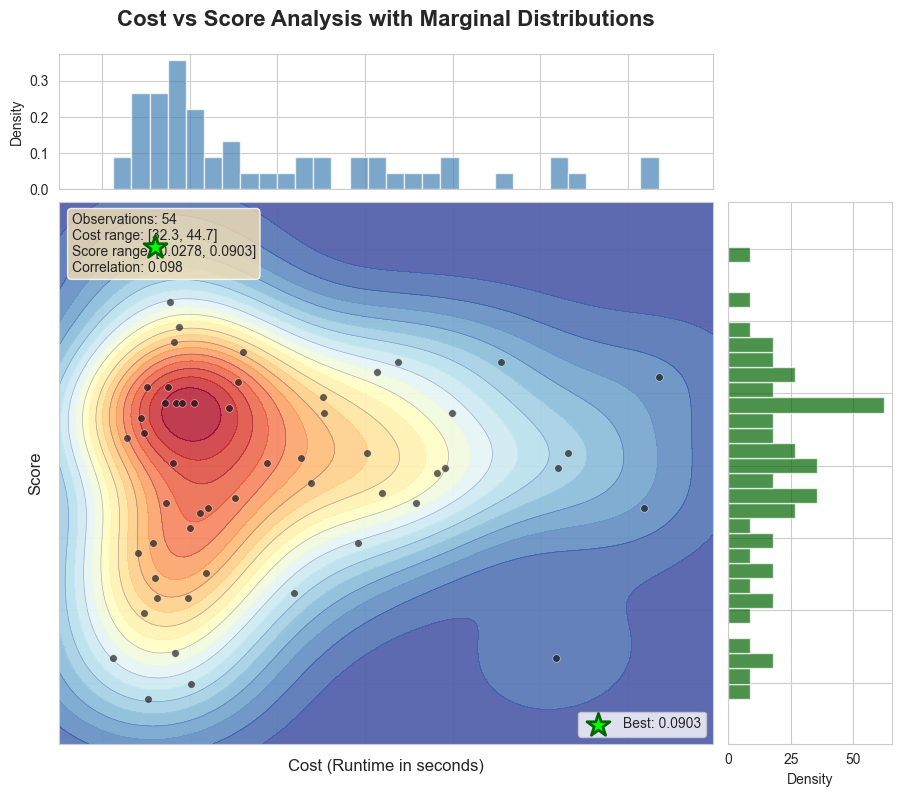

In [144]:
# Advanced visualization with marginal distributions
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        # Create figure with GridSpec for complex layout
        fig = plt.figure(figsize=(12, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05, 
                             height_ratios=[1, 4, 0.5], 
                             width_ratios=[4, 1, 0.5])
        
        # Main plot - 2D density heatmap
        ax_main = fig.add_subplot(gs[1, 0])
        
        # Top marginal - cost distribution
        ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
        
        # Right marginal - score distribution  
        ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
        
        # Main heatmap using gaussian KDE
        try:
            # Calculate 2D KDE
            from scipy.stats import gaussian_kde
            
            # Create grid for evaluation
            x_min, x_max = plot_df['cost'].min(), plot_df['cost'].max()
            y_min, y_max = plot_df['score'].min(), plot_df['score'].max()
            
            # Add padding
            x_range = x_max - x_min
            y_range = y_max - y_min
            x_min -= 0.1 * x_range
            x_max += 0.1 * x_range
            y_min -= 0.1 * y_range
            y_max += 0.1 * y_range
            
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([plot_df['cost'], plot_df['score']])
            kernel = gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)
            
            # Plot filled contours
            contourf = ax_main.contourf(xx, yy, f, levels=20, cmap='RdYlBu_r', alpha=0.8)
            
            # Add contour lines
            contour = ax_main.contour(xx, yy, f, levels=10, colors='darkblue', 
                                     alpha=0.3, linewidths=0.5)
            
            # Overlay actual data points
            scatter = ax_main.scatter(plot_df['cost'], plot_df['score'], 
                                     s=30, alpha=0.6, c='black', 
                                     edgecolors='white', linewidth=0.5)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax_main.scatter(plot_df.loc[best_idx, 'cost'], 
                           plot_df.loc[best_idx, 'score'],
                           color='lime', s=300, marker='*', 
                           edgecolors='darkgreen', linewidth=2,
                           label=f'Best: {plot_df.loc[best_idx, "score"]:.4f}',
                           zorder=100)
            
        except Exception as e:
            print(f"KDE calculation failed: {e}")
            # Fallback to simple scatter
            ax_main.scatter(plot_df['cost'], plot_df['score'], alpha=0.6)
        
        # Top marginal plot - cost distribution
        ax_top.hist(plot_df['cost'], bins=30, alpha=0.7, color='steelblue', density=True)
        ax_top.set_ylabel('Density')
        ax_top.set_xticklabels([])
        ax_top.set_title('Cost vs Score Analysis with Marginal Distributions', 
                        fontsize=16, fontweight='bold', pad=20)
        
        # Right marginal plot - score distribution
        ax_right.hist(plot_df['score'], bins=30, alpha=0.7, color='darkgreen', 
                     density=True, orientation='horizontal')
        ax_right.set_xlabel('Density')
        ax_right.set_yticklabels([])
        
        # Main plot labels
        ax_main.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
        ax_main.set_ylabel('Score', fontsize=12)
        ax_main.legend(loc='lower right')
        ax_main.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f"Observations: {len(plot_df)}\n"
        stats_text += f"Cost range: [{plot_df['cost'].min():.1f}, {plot_df['cost'].max():.1f}]\n"
        stats_text += f"Score range: [{plot_df['score'].min():.4f}, {plot_df['score'].max():.4f}]\n"
        stats_text += f"Correlation: {plot_df['cost'].corr(plot_df['score']):.3f}"
        
        ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    verticalalignment='top', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for advanced visualization")


## 4. Score Progression Over Time


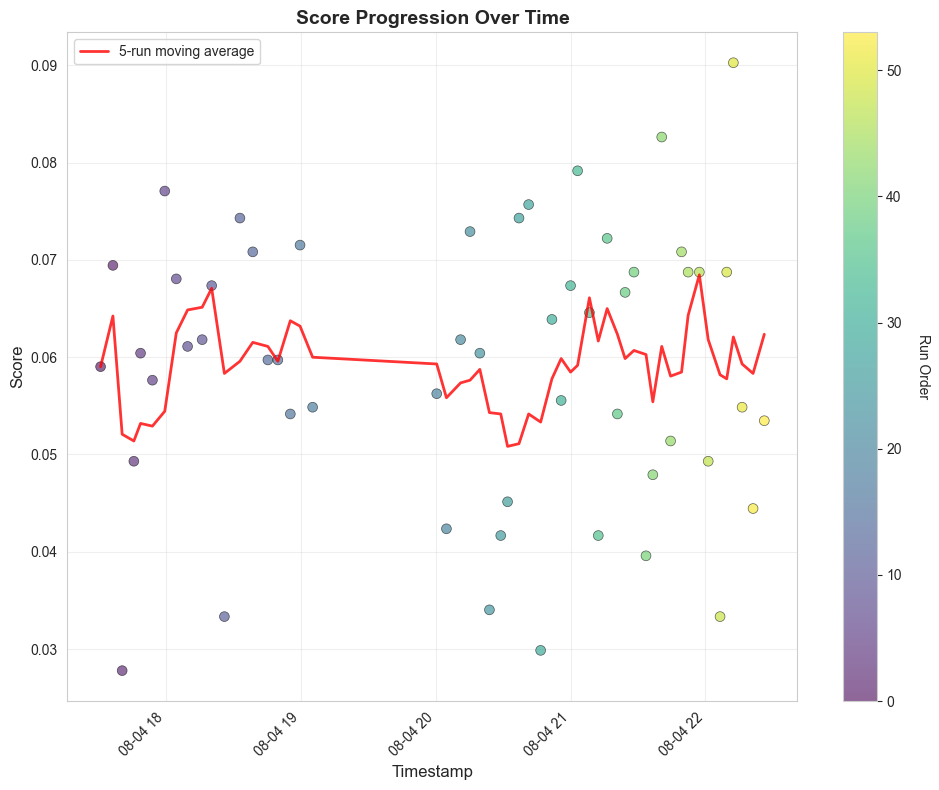

In [145]:
if not df.empty and 'timestamp' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'score']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing progression over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['score'], 
                           alpha=0.6, s=50, c=range(len(plot_df)), 
                           cmap='viridis', edgecolors='black', linewidth=0.5)
        
        # Add a trend line
        ax.plot(plot_df['timestamp'], plot_df['score'].rolling(window=5, min_periods=1).mean(), 
                color='red', linewidth=2, alpha=0.8, label='5-run moving average')
        
        # Add colorbar to show progression
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Score Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/score data to plot")
else:
    print("Missing timestamp or score data")


## 5. Runtime Progression Over Time


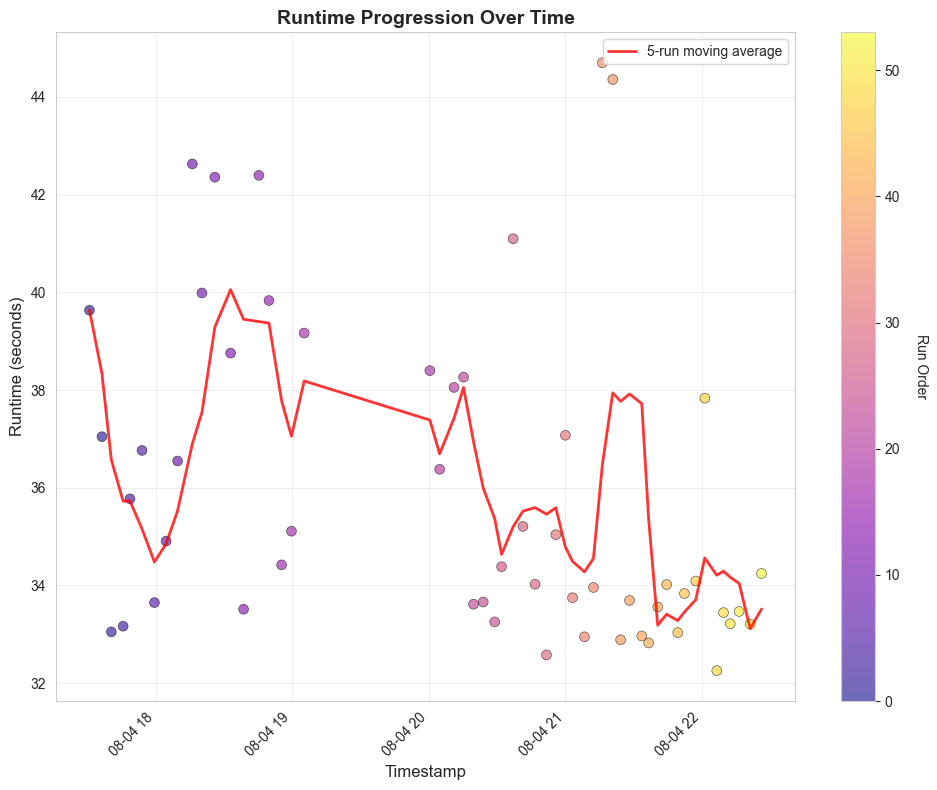

In [146]:
if not df.empty and 'timestamp' in df.columns and 'runtime' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'runtime']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing runtime over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['runtime'], 
                           alpha=0.6, s=50, c=range(len(plot_df)), 
                           cmap='plasma', edgecolors='black', linewidth=0.5)
        
        # Add a trend line
        ax.plot(plot_df['timestamp'], plot_df['runtime'].rolling(window=5, min_periods=1).mean(), 
                color='red', linewidth=2, alpha=0.8, label='5-run moving average')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Runtime (seconds)', fontsize=12)
        ax.set_title('Runtime Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/runtime data to plot")
else:
    print("Missing timestamp or runtime data")


## 6. Parameter Correlation Matrix


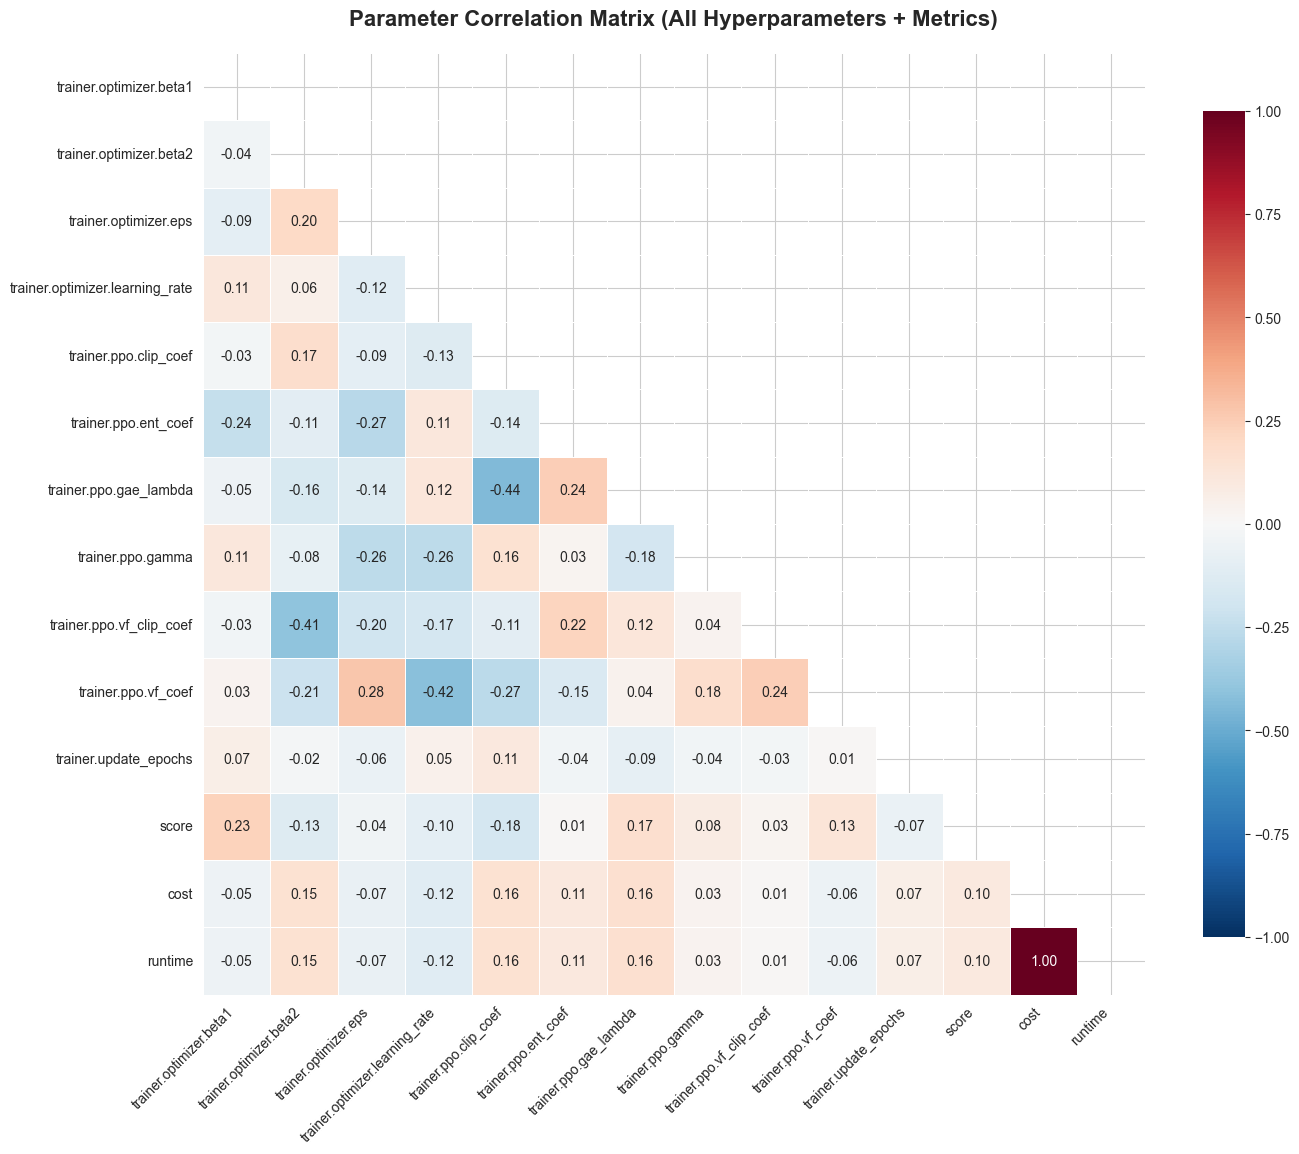

Correlation matrix includes 14 parameters
Showing top 14 most relevant parameters

Top 5 parameters most correlated with score:
  trainer.optimizer.beta1: 0.233
  trainer.ppo.clip_coef: 0.178
  trainer.ppo.gae_lambda: 0.169
  trainer.ppo.vf_coef: 0.130
  trainer.optimizer.beta2: 0.128


In [147]:
if not df.empty:
    # The df already contains flattened observation data with all hyperparameters
    # Select only numeric columns (includes score, cost, runtime, and all hyperparameters)
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Remove columns with too few unique values (less than 2)
    valid_columns = []
    for col in numeric_df.columns:
        if numeric_df[col].nunique() >= 2:
            valid_columns.append(col)
    
    if len(valid_columns) > 1:
        # Calculate correlation matrix for all valid columns
        corr_matrix = numeric_df[valid_columns].corr()
        
        # If we have too many parameters, focus on those most correlated with score
        if 'score' in corr_matrix.columns and len(corr_matrix) > 20:
            # Always include score, cost, and runtime if they exist
            essential_cols = ['score', 'cost', 'runtime']
            essential_cols = [col for col in essential_cols if col in corr_matrix.columns]
            
            # Get top correlated parameters with score (excluding the essential columns)
            score_corr = corr_matrix['score'].abs().sort_values(ascending=False)
            # Remove essential columns from the correlation list to avoid duplicates
            score_corr = score_corr.drop(essential_cols, errors='ignore')
            
            # Take top parameters plus essential columns
            top_params = essential_cols + score_corr.head(20 - len(essential_cols)).index.tolist()
            corr_matrix = corr_matrix.loc[top_params, top_params]
        
        # Create heatmap
        plt.figure(figsize=(14, 12))
        
        # Create mask for upper triangle (optional - remove if you want full matrix)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Draw heatmap
        sns.heatmap(corr_matrix, 
                   mask=mask,
                   annot=True, 
                   fmt='.2f', 
                   cmap='RdBu_r',
                   vmin=-1, 
                   vmax=1, 
                   center=0,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": 0.8})
        
        plt.title('Parameter Correlation Matrix (All Hyperparameters + Metrics)', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Correlation matrix includes {len(valid_columns)} parameters")
        print(f"Showing top {len(corr_matrix)} most relevant parameters")
        if 'score' in corr_matrix.columns:
            score_correlations = corr_matrix['score'].abs().sort_values(ascending=False)[1:6]  # Top 5 excluding self
            print("\nTop 5 parameters most correlated with score:")
            for param, corr in score_correlations.items():
                print(f"  {param}: {corr:.3f}")
    else:
        print("Not enough numeric parameters for correlation analysis")
else:
    print("No data available for correlation analysis")

## 7. Parameter Importance Analysis


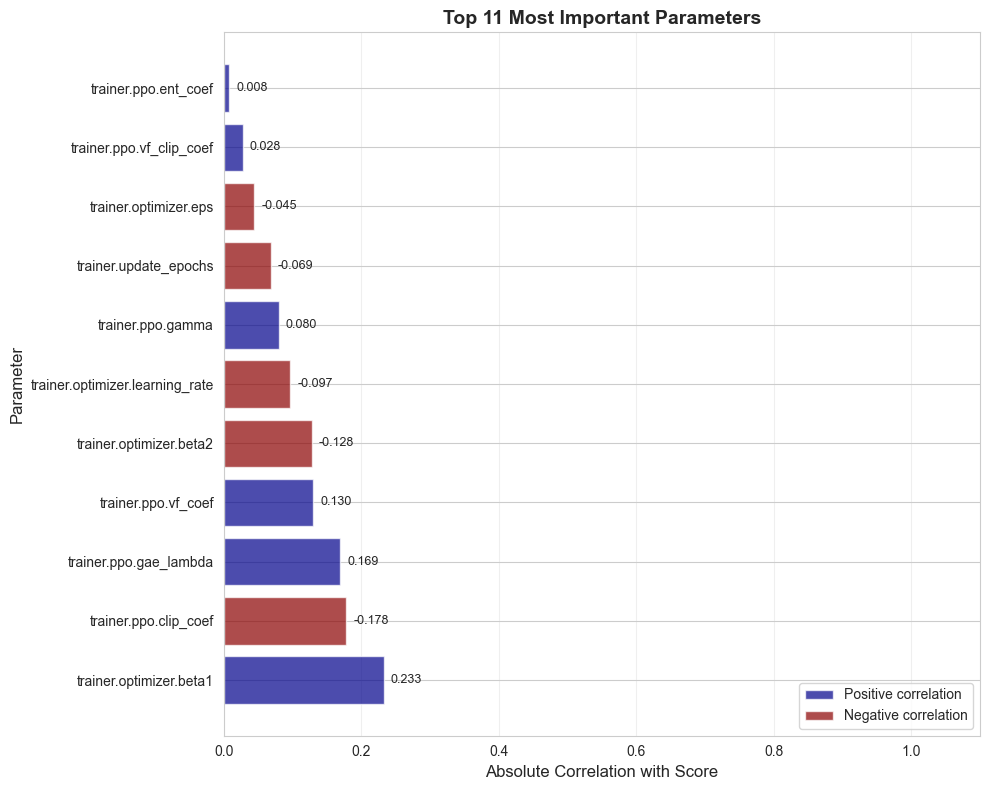


Parameter Importance Details:
trainer.optimizer.beta1        ↑ +0.2334
trainer.ppo.clip_coef          ↓ -0.1784
trainer.ppo.gae_lambda         ↑ +0.1694
trainer.ppo.vf_coef            ↑ +0.1302
trainer.optimizer.beta2        ↓ -0.1284
trainer.optimizer.learning_rate ↓ -0.0970
trainer.ppo.gamma              ↑ +0.0799
trainer.update_epochs          ↓ -0.0688
trainer.optimizer.eps          ↓ -0.0446
trainer.ppo.vf_clip_coef       ↑ +0.0277
trainer.ppo.ent_coef           ↑ +0.0082


In [148]:
if not df.empty and 'score' in df.columns:
    # Select numeric columns excluding metrics
    metric_cols = ['score', 'cost', 'runtime', 'timestamp']
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    param_cols = [col for col in numeric_cols if col not in metric_cols]
    
    if len(param_cols) > 0:
        # Calculate correlations with score
        correlations = {}
        for col in param_cols:
            # Only include if we have enough unique values
            if df[col].nunique() >= 2:
                corr = df[col].corr(df['score'])
                if not np.isnan(corr):
                    correlations[col] = corr
        
        if correlations:
            # Sort by absolute correlation
            importance_df = pd.DataFrame([
                {'parameter': k, 'correlation': v, 'abs_correlation': abs(v)}
                for k, v in correlations.items()
            ]).sort_values('abs_correlation', ascending=False).head(TOP_K_PARAMETERS)
            
            # Create importance plot
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Create color map based on correlation direction
            colors = ['darkred' if x < 0 else 'darkblue' for x in importance_df['correlation']]
            
            # Create horizontal bar plot
            bars = ax.barh(importance_df['parameter'], 
                          importance_df['abs_correlation'],
                          color=colors, alpha=0.7)
            
            # Add correlation values as text
            for i, (idx, row) in enumerate(importance_df.iterrows()):
                ax.text(row['abs_correlation'] + 0.01, i, 
                       f"{row['correlation']:.3f}",
                       va='center', fontsize=9)
            
            ax.set_xlabel('Absolute Correlation with Score', fontsize=12)
            ax.set_ylabel('Parameter', fontsize=12)
            ax.set_title(f'Top {len(importance_df)} Most Important Parameters', 
                        fontsize=14, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.grid(True, axis='x', alpha=0.3)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='darkblue', alpha=0.7, label='Positive correlation'),
                Patch(facecolor='darkred', alpha=0.7, label='Negative correlation')
            ]
            ax.legend(handles=legend_elements, loc='lower right')
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed importance table
            print("\nParameter Importance Details:")
            print("=" * 60)
            for idx, row in importance_df.iterrows():
                direction = "↑" if row['correlation'] > 0 else "↓"
                print(f"{row['parameter']:30s} {direction} {row['correlation']:+.4f}")
        else:
            print("No valid parameter correlations found")
    else:
        print("No numeric parameters found for importance analysis")
else:
    print("No score data available for importance analysis")


## 8. Additional Analysis - Best Configurations


In [149]:
# Show top performing configurations
if not df.empty and 'score' in df.columns:
    # Get top 5 configurations
    top_configs = df.nlargest(5, 'score')
    
    print("\nTop 5 Best Performing Configurations:")
    print("=" * 80)
    
    for i, (idx, row) in enumerate(top_configs.iterrows(), 1):
        print(f"\nRank {i}: Score = {row['score']:.4f}, Runtime = {row.get('runtime', 'N/A')}s")
        if 'timestamp' in row and pd.notna(row['timestamp']):
            print(f"         Created at: {row['timestamp']}")
        print("-" * 40)
        
        # Show only parameters that differ from the median
        param_cols = [col for col in df.columns if col not in ['score', 'cost', 'runtime', 'timestamp']]
        for col in param_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                if abs(row[col] - median_val) > 0.01 * abs(median_val):  # More than 1% different
                    print(f"  {col}: {row[col]:.4f} (median: {median_val:.4f})")



Top 5 Best Performing Configurations:

Rank 1: Score = 0.0903, Runtime = 33.21587586402893s
         Created at: 2025-08-04 22:12:25+00:00
----------------------------------------
  trainer.optimizer.eps: 0.0000 (median: 0.0000)
  trainer.optimizer.learning_rate: 0.0089 (median: 0.0004)
  trainer.ppo.clip_coef: 0.1899 (median: 0.1743)
  trainer.ppo.ent_coef: 0.0021 (median: 0.0020)
  trainer.ppo.gamma: 0.9652 (median: 0.9906)
  trainer.ppo.vf_clip_coef: 7.7610 (median: 8.3423)
  trainer.ppo.vf_coef: 0.4100 (median: 0.6637)

Rank 2: Score = 0.0826, Runtime = 33.55768179893494s
         Created at: 2025-08-04 21:40:33+00:00
----------------------------------------
  trainer.optimizer.beta1: 0.8943 (median: 0.9039)
  trainer.optimizer.eps: 0.0000 (median: 0.0000)
  trainer.optimizer.learning_rate: 0.0000 (median: 0.0004)
  trainer.ppo.clip_coef: 0.0664 (median: 0.1743)
  trainer.ppo.ent_coef: 0.0022 (median: 0.0020)
  trainer.ppo.vf_clip_coef: 9.2270 (median: 8.3423)
  trainer.ppo.vf_coe

## 9. Export Results


In [150]:
# Optional: Export processed data for further analysis
if not df.empty:
    output_file = f"sweep_analysis_{WANDB_SWEEP_ID}.csv"
    df.to_csv(output_file, index=False)
    print(f"\nExported sweep data to: {output_file}")
    print(f"Total rows exported: {len(df)}")



Exported sweep data to: sweep_analysis_None.csv
Total rows exported: 54
